In [1]:
# declare a list tasks whose products you want to use as inputs
upstream = None


In [2]:
# Parameters
product = {
    "nb": "/Users/macpro/Documents/GitHub/fuel-electric-hybrid-vehicle-ml/notebooks/clustering.ipynb"
}


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from pathlib import Path

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import silhouette_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage

In [6]:
# Get the current working directory
current_working_directory = os.getcwd()

In [7]:
# Convert the current working directory to a Path object
script_dir = Path(current_working_directory)

In [8]:
def merge_vehicle_id(df):
    df['vehicle_id'] = df['vehicle_type'] + '_' + df['id'].astype(str)

    df.drop(['id'], axis=1, inplace=True)
    return df

In [9]:
def read_and_clean_vehicle_data(clean_data_path):
    """
    
    This function reads the cleaned data from the data/processed folder and returns a dataframe

    Parameters
    ----------
    clean_data_path : Path
        Path to the data/processed folder

    Returns
    ------- 
    fuel_df : DataFrame
        A dataframe containing the cleaned fuel data
    hybrid_df : DataFrame
        A dataframe containing the cleaned hybrid data
    electric_df : DataFrame
        A dataframe containing the cleaned electric data
    """

    # Read the data
    fuel_df = pd.read_csv(Path(clean_data_path,"predicted_co2_rating.csv"))
    hybrid_df = pd.read_csv(Path(clean_data_path,"predicted_co2_rating_hybrid.csv"))
    electric_df = pd.read_csv(Path(clean_data_path,"predicted_co2_rating_electric.csv"))

    # drop the 'original_co2r' column from the dataframes
    fuel_df.drop('original_co2r', axis=1, inplace=True)

    # rename co2_rating to predicted_co2r in hybrid_df and electric_df
    hybrid_df.rename(columns={'co2_rating': 'predicted_co2_rating'}, inplace=True)
    electric_df.rename(columns={'co2_rating': 'predicted_co2_rating'}, inplace=True)

    # rename fuel_type1 to fuel_type in fuel_df, hybrid_df, and electric_df
    fuel_df.rename(columns={'fuel_type1': 'fuel_type'}, inplace=True)
    hybrid_df.rename(columns={'fuel_type1': 'fuel_type'}, inplace=True)
    electric_df.rename(columns={'fuel_type1': 'fuel_type'}, inplace=True)

    return fuel_df, hybrid_df, electric_df

In [10]:
def concat_vehicle_data(fuel_df, hybrid_df, electric_df):

    df = pd.concat([fuel_df, hybrid_df, electric_df], axis=0, ignore_index=True)

   
    # move vehicle_id to the first column
    cols = df.columns.tolist()

    # obtain position of vehicle_id column from cols
    vehicle_id_index = cols.index('vehicle_id')

    # move vehicle_id to the first column
    cols = [cols[vehicle_id_index]] + cols[:vehicle_id_index] + cols[vehicle_id_index+1:]

    df = df[cols]

    # fill missing values with 0
    df.fillna(0, inplace=True)

    # convert categorical columns to a categorical variable
    cat_cols = df.select_dtypes(exclude=np.number).columns
    for col in cat_cols:
        df[col] = df[col].astype('category')

    return df

In [11]:
def prepare_data_feature_importances(df):
    # Select the columns with numerical and categorical data
    num_cols = df.select_dtypes(include=np.number).columns

    # One-hot encode the categorical columns
    df_cat = pd.get_dummies(df[['mapped_fuel_type']])
    df_num = df[num_cols]

    # Combine the numerical and one-hot encoded categorical dataframes
    df_processed = pd.concat([df_num, df_cat], axis=1)

    return df_processed

In [12]:
def generate_feature_importances(df_processed, reports_path, target_col):

    # Perform recursive feature elimination to select the most important features
    X = df_processed.drop([target_col], axis=1)
    y = df_processed[target_col]

    X_scaled = StandardScaler().fit_transform(X)

    # set up xgboost model for classification and feature selection
    dt = DecisionTreeClassifier(random_state=42)
    rfecv = RFECV(estimator=dt, cv=10)
    rfecv.fit(X_scaled, y)

    # predict
    y_pred = rfecv.predict(X_scaled)

    # Print the accuracy
    print("Accuracy:", metrics.accuracy_score(y, y_pred))

    # Fit a decision tree and get feature importances
    dt.fit(X, y)
    feat_importances = pd.Series(dt.feature_importances_, index=X.columns)

    # Plot the feature importances
    plt.figure(figsize=(15,6))
    plt.title(f'Decision Tree Feature Importances - variable: {target_col}')
    feat_importances.nlargest(15).plot(kind='barh')

    # save the plot
    plt.savefig(f'{reports_path}/feature_importances_{target_col.split("(")[0]}.png')
    plt.clf()

    # Select the top 5 most important features
    threshold = feat_importances.nlargest(15).min()
    top_features = feat_importances[feat_importances >= threshold].index.tolist()

    return top_features, X, y

In [13]:
def generate_clustering(X, top_features, range_n_clusters, reports_path):
    # select the top features
    X = X[top_features]

    # scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[top_features])

    # initialize lists to store the scores
    silhouette_scores = []
    silhouette_scores_cl = []
    inertia_scores = []

    # loop over the range of cluster numbers
    for n_clusters in range_n_clusters:
        
        # initialize KMeans with n_clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init=10)
        
        # fit KMeans to the data
        kmeans.fit(X_scaled)

        # initialize AgglomerativeClustering with n_clusters
        agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
        
        # fit AgglomerativeClustering to the data
        agg_clustering.fit(X_scaled)
        
        # calculate the inertia score (within-cluster sum of squares)
        inertia_scores.append(kmeans.inertia_)
        
        # calculate the silhouette score
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_avg_cl = silhouette_score(X_scaled, agg_clustering.labels_)
        silhouette_scores_cl.append(silhouette_avg_cl)
        silhouette_scores.append(silhouette_avg)
        
        # print the scores
        print("For n_clusters =", n_clusters,
            "The inertia score is :", kmeans.inertia_,
            "The average silhouette score is :", silhouette_avg,
            "The average silhouette score (clustering) is :", silhouette_avg_cl)


    return silhouette_scores, silhouette_scores_cl, inertia_scores

In [14]:
def plot_elbow_method(silhouette_scores, silhouette_scores_cl, inertia_scores,\
                       range_n_clusters, target_col, reports_path):
    # plot the elbow curve
    # clear the plot

    plt.figure(figsize=(10,10))
    plt.plot(range_n_clusters, inertia_scores, 'bx-')
    plt.xlabel('Number of Clusters')
    # set xticks to be the range of cluster numbers
    plt.xticks(range_n_clusters)
    plt.ylabel('Inertia Score')
    plt.title(f'Elbow Method for Optimal k - {target_col}')
    # save the plot
    plt.savefig(f'{reports_path}/elbow_method_{target_col.split("(")[0]}.png')

    # clear the plot
    plt.clf()

    # plot the silhouette scores
    plt.figure(figsize=(10,10))
    plt.plot(range_n_clusters, silhouette_scores, 'bx-')
    plt.xlabel('Number of Clusters')
    # set xticks to be the range of cluster numbers
    plt.xticks(range_n_clusters)
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Method for Optimal k - {target_col}')
    # save the plot
    plt.savefig(f'{reports_path}/silhouette_method_{target_col.split("(")[0]}.png')
    # clear the plot
    plt.clf()

    # plot the silhouette scores
    plt.figure(figsize=(10,10))
    plt.plot(range_n_clusters, silhouette_scores_cl, 'bx-')
    plt.xlabel('Number of Clusters')
    # set xticks to be the range of cluster numbers
    plt.xticks(range_n_clusters)
    plt.ylabel('Silhouette Score (clustering)')
    plt.title(f'Silhouette Method for Optimal k  (clustering) - {target_col}')
    # save the plot
    plt.savefig(f'{reports_path}/silhouette_method_clustering_{target_col.split("(")[0]}.png')
    # clear the plot
    plt.clf()

In [15]:
def perform_clustering(X,n_clusters, top_features):

    # scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[top_features])

    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

    agg_clustering.fit(X_scaled)
    y_pred = agg_clustering.fit_predict(X_scaled)
    cluster_labels = agg_clustering.labels_

    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    # Plot the t-SNE with colors based on cluster assignments
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap=plt.cm.get_cmap('viridis', n_clusters))
    plt.colorbar(ticks=range(n_clusters), label='Cluster Labels')
    plt.clim(-0.5, n_clusters - 0.5)
    plt.savefig(f"{reports_path}/tsne_results_{n_clusters}_clusters.png")

    return cluster_labels, y_pred

In [16]:
# define a function to add a column with zero and one values, where 1 indicates a hybrid or electric vehicle and 0 indicates a fuel vehicle
def add_hybrid_electric_col(df, fuel_attribute):
    return df['vehicle_type'].apply(lambda x: 1 if x in ['hybrid', fuel_attribute] else 0)

In [17]:
def plot_agg_clustering_dendrogram(df, X, labels_agg, reports_path):
    plt.figure(figsize=(10, 6))

    Z = linkage(X, 'ward')
    dendrogram(Z, labels=labels_agg)

    plt.xlabel('Data Points')
    plt.ylabel('Euclidean Distance')
    plt.title("Agglomerative Clustering Dendrogram")
    plt.savefig(f"{reports_path}/agg_clustering_dendrogram.png")

In [18]:
def compute_performance(df, labels_agg, reports_path, target):

    name = target.replace('_',' ').title()
    print('Classification peformance, view: ', name)
    
    cm = confusion_matrix(df[target],labels_agg)
    print(cm)
    cr = classification_report(df[target],labels_agg)
    print(cr)
    with open(f'{reports_path}/clustering_performance_kmeans_{target}.txt', 'w') as f:
        f.write(f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{cr}')

Accuracy: 1.0


FileNotFoundError: [Errno 2] No such file or directory: '/Users/macpro/Documents/GitHub/fuel-electric-hybrid-vehicle-ml/notebooks/reports/figures/feature_importances_predicted_co2_rating.png'

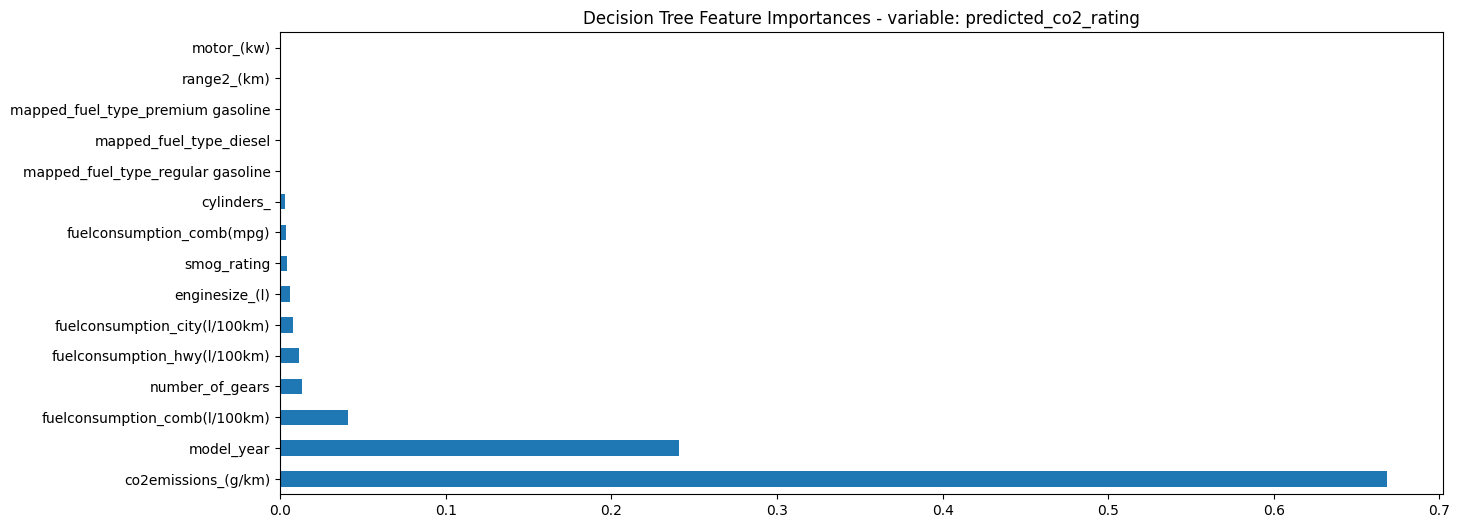

In [20]:
if __name__ == "__main__":

    # Get the current working directory
#     predicted_data_path = script_dir / 'data' / 'predicted-data'
#     model_path = script_dir / 'models' / 'hard_voting_classifier_co2_fuel.pkl'
#     reports_path= script_dir / 'reports'/ 'figures'

    predicted_data_path ='/Users/macpro/Documents/GitHub/fuel-electric-hybrid-vehicle-ml/data/predicted-data/'


    # Load data
    fuel_df, hybrid_df, electric_df = read_and_clean_vehicle_data(predicted_data_path)

    # merge vehicle_type and id into a single column for fuel_df
    fuel_df = merge_vehicle_id(fuel_df)

    # set fuel_df to contain only cars from 2012 onwards
    fuel_df = fuel_df[fuel_df['model_year'] >= 2012]
    hybrid_df = merge_vehicle_id(hybrid_df)
    electric_df = merge_vehicle_id(electric_df)

    # Concatenate the dataframes
    df = concat_vehicle_data(fuel_df, hybrid_df, electric_df)

    # add a column with zero and one values, where 1 indicates a hybrid or electric vehicle and 0 indicates a fuel vehicle
    df['hybrid_in_fuel'] = add_hybrid_electric_col(df, 'electric')
    df['hybrid_in_electric'] = add_hybrid_electric_col(df, 'fuel-only')

    # prepare data for feature importances
    target_col = 'predicted_co2_rating'
    df_processed = prepare_data_feature_importances(df)

    # generate feature importances
    top_features, X, y = generate_feature_importances(df_processed, reports_path, target_col)

    # # # generate clustering
    # range_n_clusters = range(2, 11)
    
    # # generate clustering
    # silhouette_scores, \
    #     silhouette_scores_cl, \
    #         inertia_scores = generate_clustering(X, top_features, range_n_clusters, reports_path)
    
    # # plot the elbow method
    # plot_elbow_method(silhouette_scores, silhouette_scores_cl, inertia_scores,\
    #                       range_n_clusters, target_col, reports_path)
    
    # perform clustering - kmeans
    n_clusters = 2
    labels_agg, y_pred = perform_clustering(X , n_clusters, top_features) # X ,y,  n_clusters, top_features

    # add the labels to the dataframe
    df['aggregate_levels'] = labels_agg

    # Save confusion matrix and classification report
    target_a = 'hybrid_in_fuel'
    compute_performance(df, labels_agg, reports_path, target_a)

    # plot the dendrogram
    plot_agg_clustering_dendrogram(df, X, labels_agg, reports_path)

    # Transform vehicle_type to numeric
    df['vehicle_type_cat'] = df['vehicle_type'].map({'fuel-only': 0, 'electric': 1, 'hybrid': 2})

  # save the dataframe
    df.to_csv(f'{predicted_data_path}/vehicle_data_with_clusters.csv', index=False)

In [25]:
hybrid_df

,model_year,make_,model.1_,vehicleclass_,motor_(kw),enginesize_(l),cylinders_,transmission_,fuel_type,consumption_combinedle/100km,...,range2_(km),co2emissions_(g/km),predicted_co2_rating,smog_rating,transmission_type,number_of_gears,mapped_fuel_type,hybrid_fuels,vehicle_type,vehicle_id
0,2012,chevrolet,volt,compact,111,1.4,4.0,AV,B,2.5 (22.3 kWh/100 km),...,550,54,10.0,7.0,continuously variable,NaN,premium gasoline,electricity,hybrid,hybrid_1
1,2013,chevrolet,volt,compact,111,1.4,4.0,AV,B,2.4 (21.4 kWh/100 km),...,550,45,10.0,7.0,continuously variable,NaN,premium gasoline,electricity,hybrid,hybrid_2
2,2013,ford,c-max energi,mid-size,35,2.0,4.0,AV,B/X,2.7 ([23.2 kWh + 0.1 L]/100 km),...,856,80,10.0,8.0,continuously variable,NaN,regular gasoline,electricity & regular gasoline,hybrid,hybrid_3
3,2013,ford,fusion energi,mid-size,35,2.0,4.0,AV,B/X,2.7 ([23.2 kWh + 0.1 L]/100 km),...,856,80,10.0,8.0,continuously variable,NaN,regular gasoline,electricity & regular gasoline,hybrid,hybrid_4
4,2013,toyota,prius plug-in hybrid,mid-size,60,1.8,4.0,AV,B/X,2.5 ([18.0 kWh + 0.4 L]/100 km),...,845,101,10.0,8.0,continuously variable,NaN,regular gasoline,electricity & regular gasoline,hybrid,hybrid_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2023,volvo,s60 t8 awd recharge,compact,107,2.0,4.0,AS8,B/Z*,3.0 ([27.2 kWh + 0.0 L]/100 km),...,792,58,10.0,7.0,automatic with select Shift,8.0,premium gasoline,electricity & premium gasoline,hybrid,hybrid_244
244,2023,volvo,s90 t8 awd recharge,mid-size,107,2.0,4.0,AS8,B/Z*,3.4 ([30.0 kWh + 0.0 L]/100 km),...,748,65,10.0,7.0,automatic with select Shift,8.0,premium gasoline,electricity & premium gasoline,hybrid,hybrid_245
245,2023,volvo,v60 t8 awd recharge,station wagon - small,107,2.0,4.0,AS8,B/Z*,3.0 ([27.2 kWh + 0.0 L]/100 km),...,792,58,10.0,7.0,automatic with select Shift,8.0,premium gasoline,electricity & premium gasoline,hybrid,hybrid_246
246,2023,volvo,xc60 t8 awd recharge,suv - small,107,2.0,4.0,AS8,B/Z*,3.5 ([31.2 kWh + 0.0 L]/100 km),...,838,72,10.0,7.0,automatic with select Shift,8.0,premium gasoline,electricity & premium gasoline,hybrid,hybrid_247


In [39]:
df[df['vehicle_type']=='fuel-only'][['vehicle_id','vehicle_type','motor_(kw)']]['motor_(kw)'].sum()

0.0